***`Business Context`***,

In today's highly competitive market, maximizing **customer loyalty** is a top priority for businesses. Understanding the key **drivers** that hold the most value for customers is crucial in developing effective strategies to enhance loyalty.
<br><br>
To gain **insights** into customer loyalty, a comprehensive dataset comprising multiple surveys conducted among clients has been compiled. The primary objective is to identify the key **features and factors** that significantly influence customer loyalty.<br>
By analyzing this data, businesses can make informed decisions and tailor their offerings to better meet customer needs, ultimately fostering stronger loyalty and long-term customer relationships.

*packages*

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests, random, time
import numpy as np
from math import pi

# shap
import shap 

# scikitlearn
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, decomposition
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import *

# To plot pretty figures
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

*functions*

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

In [3]:
def define_clfs_params():

    clfs = {
        'LR': LogisticRegression(penalty='l1', C=0.05, solver = 'liblinear', random_state = 42),
        'SVM': svm.SVC(kernel = 'poly', degree = 3, probability = True, random_state = 42),
        'SGD': SGDClassifier(loss="modified_huber", penalty="l2", alpha=0.01),
            }
    
    grid = {     
    'LR': {'penalty': ['l1','l2'], 'C': [0.00001, 0.001, 0.01, 0.1, 1, 10]},
    'SVM' :{'C' :[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],'degree':[2, 3, 4, 7]},
    'SGD': {'loss': ['modified_huber', 'perceptron'], 'penalty': ['l2','l1','elasticnet'], 
            'alpha':[0.00001, 0.001, 0.01, 0.1, 1, 10]}
           }    
            
    return clfs, grid

In [4]:
def clf_loop(clfs, grid, X_train, y_train, X_test, y_test):
    results_df =  pd.DataFrame(columns=('model','clf', 'score', 'auc-roc', 
                                        'score with grid', 'auc-roc with grid', 'best parameters'))
    models_to_run = ['LR', 'SVM', 'SGD']
    
    for m in models_to_run:        
        # model
        model = clfs[m]
        model.fit(X_train, y_train)
        
        # get score & ROC AUC
        y_pred = model.predict(X_test)
        score = model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        #grid search
        model_grid = GridSearchCV(model, grid[m], cv = 7)
        model_grid.fit(X_train, y_train)                    
        
        # get score & ROC AUC (grid)
        y_predg = model_grid.predict(X_test)
        scoreg = model_grid.score(X_test, y_test)
        roc_aucg = roc_auc_score(y_test, y_predg)        
                
        buffer = pd.DataFrame(data = [m, model, score, roc_auc, scoreg, roc_aucg, model_grid.best_params_],
                              index=('model','clf', 'score', 'auc-roc', 
                                       'score with grid', 'auc-roc with grid', 'best parameters')).T
        results_df = pd.concat([results_df, buffer], axis = 0)
    return results_df.reset_index(drop = True)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate', fontsize = 16)
    

*set the connection to the database*

In [5]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

*query and load the data*

In [6]:
q = """
    select
            *
    from
            kaggle_data.starbucks.survey_clean;
"""

df = pd.read_sql(sql = q, con = db_conn_post)
df.head(3)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,Id,gender,age,status,income,visitNo,method,timeSpend,location,membershipCard,...,chooseRate,promoMethodApp,promoMethodSoc,promoMethodEmail,promoMethodDeal,promoMethodFriend,promoMethodDisplay,promoMethodBillboard,promoMethodOthers,loyal
0,1,1,1,0,0,3,0,1,0,0,...,3,1,1,1,1,1,1,1,1,0
1,2,1,1,0,0,3,2,0,1,0,...,2,1,1,1,1,1,1,1,1,0
2,3,0,1,2,0,2,0,1,2,0,...,3,1,1,1,1,1,1,1,1,0


In the context of our **analysis**, we have conducted a comprehensive survey encompassing various features that influence customer satisfaction. <br>
For the purpose of this example, we will focus on the following key features: product rate, price rate, promo rate, ambiance rate, WiFi rate, service rate, and choice rate.<br>
These features have been carefully selected to provide valuable **insights** into the factors that contribute to customer **perception** and overall **experience**. By examining these aspects, we aim to gain a deeper understanding of customer preferences and identify areas for **improvement** in our **offerings**.

In [7]:
for column in df.columns:
    print(column)

Id
gender
age
status
income
visitNo
method
timeSpend
location
membershipCard
itemPurchaseCoffee
itempurchaseCold
itemPurchasePastries
itemPurchaseJuices
itemPurchaseSandwiches
itemPurchaseOthers
spendPurchase
productRate
priceRate
promoRate
ambianceRate
wifiRate
serviceRate
chooseRate
promoMethodApp
promoMethodSoc
promoMethodEmail
promoMethodDeal
promoMethodFriend
promoMethodDisplay
promoMethodBillboard
promoMethodOthers
loyal


*In the context of the analysis,*
 - 1 is very bad
 - 5 excellent
 
*And the raw question was,*
- How would you rate the quality of Starbucks compared to other brands (Coffee Bean, Old Town White Coffee..)
- How would you rate the price range at Starbucks?	
- How important are sales and promotions in your purchase decision?	
- How would you rate the ambiance at Starbucks? (lighting, music, etc...)	
- You rate the WiFi quality at Starbucks as..	
- How would you rate the service at Starbucks? (Promptness, friendliness, etc..)	
- How likely you will choose Starbucks for doing business meetings or hangout with friends?

To facilitate a comprehensive analysis, we will rescale the features on a range from 0 to 10, this approach enables us to prioritize actions and allocate resources based on the perceived significance and value of each feature within the utility function.

\begin{gather*}
z = \beta_{1}product + \beta_{2}price + \beta_{3}ambiance + \beta_{4}service + \beta_{5}promo + \beta_{6}wifi + \beta_{7}choose\\
\end{gather*}

In [8]:
df_in = df.filter(like = 'Rate', axis = 'columns') #df_in: data frame insights
df_in = df_in * 2
df_in = pd.concat([df_in, df['loyal']], axis = 1)

In [9]:
df_in.head()

,productRate,priceRate,promoRate,ambianceRate,wifiRate,serviceRate,chooseRate,loyal
0,8,6,10,10,8,8,6,0
1,8,6,8,8,8,10,4,0
2,8,6,8,8,8,8,6,0
3,4,2,8,6,6,6,6,1
4,6,6,8,4,4,6,6,0


In this analysis, we approach the problem as a **classification** task with a binary outcome, where the value of 0 represents **non-loyalty** and 1 represents **loyalty.** It is important to note that the distribution of the output variable is imbalanced, meaning that the number of instances in each class is unequal. <br><br>

While this scenario is not uncommon in real-world situations, it poses a challenge in accurately predicting the minority class. To address this imbalance and ensure reliable model performance, appropriate techniques such as resampling or adjusting class weights can be employed to provide a more balanced representation and enhance the model's ability to accurately classify instances from both classes.

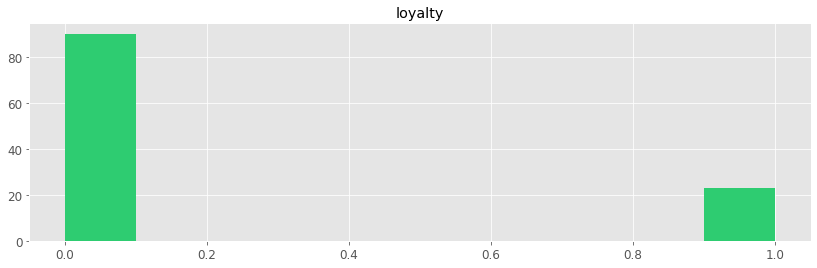

In [10]:
plt.figure(figsize = (14, 4))
plt.hist(x = df_in['loyal'], color = '#2ECC71')
plt.title('loyalty')
plt.show()

In [11]:
loyal = df_in[df_in['loyal'] == 1]

In [12]:
loyal = pd.DataFrame(loyal.mean()).T.drop(columns = 'loyal')

In [13]:
loyal

,productRate,priceRate,promoRate,ambianceRate,wifiRate,serviceRate,chooseRate
0,6.26087,3.913043,7.73913,6.869565,6.086957,7.217391,5.652174


Based on the radar chart analysis, it becomes evident that **loyal** clients highly **value promotional offers** and excellent **service**, while the aspect with the **lowest** rating is the **pricing**.

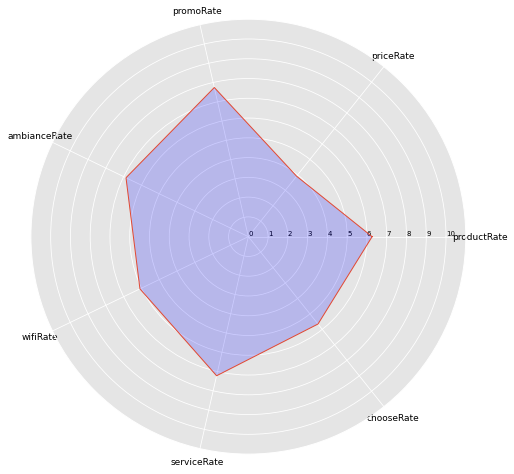

In [14]:
plt.figure(figsize = (18, 8))

# Set data
df = loyal
 
# number of variable
categories=list(df.columns)
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=9)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
           ["0","1", "2", "3", "4","5", "6", "7", "8", "9", "10"], 
           color="black", 
           size=7)
plt.ylim(0, 11)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.2)

# Show the graph
plt.show()

*Split the data - train & test*

In [15]:
df_train, df_test = train_test_split(df_in, train_size = 0.8, random_state = 42, shuffle = True)

In [16]:
df_train.head(1)

,productRate,priceRate,promoRate,ambianceRate,wifiRate,serviceRate,chooseRate,loyal
31,8,6,6,6,4,6,8,0


In [17]:
# train
X_train = df_train.drop(columns = ['loyal'], inplace = False)
y_train = df_train['loyal']

# test
X_test = df_test.drop(columns = ['loyal'], inplace = False)
y_test = df_test['loyal']

In [18]:
print('train-len: ', len(df_train))
print('test-len: ', len(df_test))

train-len:  90
test-len:  23


Fortunately, this dataset does not contain any missing values, eliminating the need for imputation techniques. Additionally, as part of the initial preprocessing steps, we have already performed data scaling, which ensures that the features are appropriately scaled and eliminates the necessity for standard scaling. This allows us to proceed directly with the subsequent stages of analysis and modeling.

In [19]:
X_train.isnull().sum()

productRate     0
priceRate       0
promoRate       0
ambianceRate    0
wifiRate        0
serviceRate     0
chooseRate      0
dtype: int64

In [20]:
y_train.isnull().sum()

0

In approaching this problem, we aim to frame it as a classification task with the objective of identifying loyal and non-loyal clients. To achieve this, we will employ three distinct algorithms: logistic regression, support vector machine, and Stochastic Gradient Descent (SGD).

Finally, we will compare the models to determine which one best generalizes the behavior of the consumers.

In [21]:
clfs, grid = define_clfs_params()

In [22]:
results = clf_loop(clfs, grid, X_train, y_train, X_test, y_test)

Based on our current analysis, the `Support Vector Machine (SVM)` emerges as the optimal model, exhibiting a C value of 0.01 and a degree of 3. Initially, the model's AUC-ROC performance was around 0.5. However, through a rigorous cross-validation grid, we were able to significantly enhance its AUC-ROC score, achieving an improved value of 0.62. This outcome demonstrates the effectiveness of the SVM with the selected hyperparameters and highlights the importance of thorough evaluation and fine-tuning to enhance our predictive capabilities.
<br><br><br>
The `Area Under the ROC Curve (ROC-AUC)` measures the model's ability to distinguish between the two classes, regardless of the classification threshold.
<br><br>
Advantages:
- It is useful when classes are imbalanced since it is not affected by the class distribution and provides an aggregated measure of model performance.
- It is a robust metric widely used in various fields.

Disadvantages:
- It does not consider the actual data distribution and can be misleading if there is class imbalance.

In [23]:
results

,model,clf,score,auc-roc,score with grid,auc-roc with grid,best parameters
0,LR,"LogisticRegression(C=0.05, penalty='l1', rando...",0.869565,0.5,0.826087,0.475,"{'C': 10, 'penalty': 'l1'}"
1,SVM,"SVC(kernel='poly', probability=True, random_st...",0.73913,0.566667,0.826087,0.616667,"{'C': 0.01, 'degree': 3}"
2,SGD,"SGDClassifier(alpha=0.01, loss='modified_huber')",0.304348,0.6,0.521739,0.583333,"{'alpha': 1e-05, 'loss': 'perceptron', 'penalt..."


To assess the model's efficiency, we will proceed with plotting the recall-precision curve.

In [24]:
svm_c = svm.SVC(kernel = 'poly', 
                C = 0.01,
                degree = 3, 
                probability = True, 
                random_state = 42)

In [25]:
svm_c.fit(X_train, y_train)

SVC(C=0.01, kernel='poly', probability=True, random_state=42)

In [26]:
y_scores = cross_val_predict(svm_c, X_train, y_train, cv = 3)

In [27]:
y_scores.shape

(90,)

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

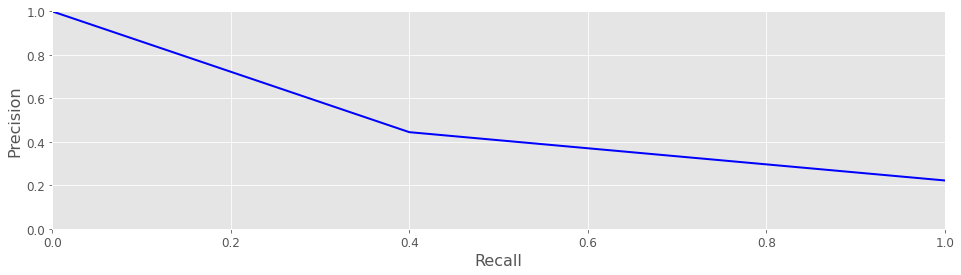

In [29]:
plt.figure(figsize = (16, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [30]:
precision_score(y_train, y_scores)

0.4444444444444444

In [31]:
recall_score(y_train, y_scores)

0.4

In [32]:
fpr, tpr, thersholds = roc_curve(y_train, y_scores)

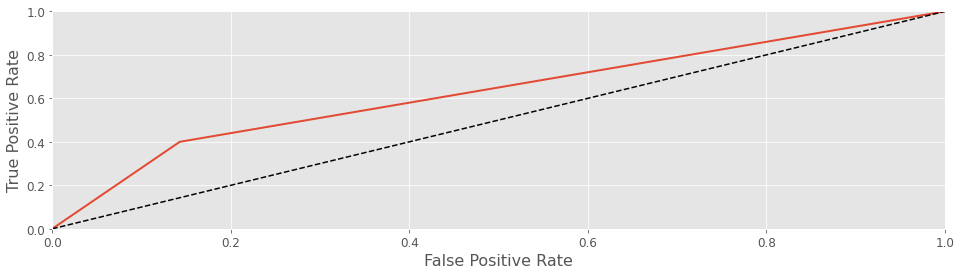

In [33]:
plt.figure(figsize = (16,4))
plot_roc_curve(fpr, tpr)
plt.show()